In [ ]:
!pip install matplotlib

In [2]:
import sys
import warnings
from enum import auto, Enum

from pathlib import Path

import matplotlib.pyplot as plt

warnings.filterwarnings( "ignore", module = "matplotlib\\..*" )

In [3]:
here = Path()
root = here / ".."
root.exists()

True

In [4]:
sys.path.insert(0, str(root))

In [5]:
from bhr.pipe import Pipe

In [6]:
def lpm_to_m3s(x):
    return x / 1000 / 60

In [7]:
def inch_to_m(x):
    return x * 0.0254

In [8]:
flow_lpm = range(0, 61, 1)
flow_m3s = [lpm_to_m3s(x) for x in flow_lpm]

In [9]:
class UTubeType(Enum):
    SINGLE = auto()
    DOUBLEPARALLEL = auto()
    DOUBLESERIES = auto()

In [10]:
def get_pressure_loss_per_meter_bh(bh_flow_m3s, fluid_name, fluid_conc, temp, od_inch, pipe_type):
    
    bh_length = 100
    u_pipe_length = bh_length * 2

    if pipe_type == UTubeType.SINGLE:
        pipe_length = u_pipe_length
        bh_flow = bh_flow_m3s
    elif pipe_type == UTubeType.DOUBLEPARALLEL:
        pipe_length = u_pipe_length
        bh_flow = [x/2 for x in bh_flow_m3s]
    elif pipe_type == UTubeType.DOUBLESERIES:
        pipe_length = u_pipe_length * 2
        bh_flow = bh_flow_m3s
        
    p = Pipe(
        pipe_outer_diameter=inch_to_m(od_inch),
        pipe_dimension_ratio=11,
        pipe_length=pipe_length,
        pipe_conductivity=0.4,
        fluid_type=fluid_name,
        fluid_concentration=fluid_conc)

    dp = [p.pressure_loss_v_dot(x, temp=temp) / bh_length for x in bh_flow]

    return dp

In [11]:
def plot_fill_between(x, y_l, y_m, y_h, ax, color, label, **kwargs):
    ax.plot(x, y_m, color=color, label=label)
    ax.fill_between(x, y_l, y_h, color=color, alpha=0.2, label=' ')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(h1, h2) for h1, h2 in zip(handles[::2], handles[1::2])],
              labels=[l1 + "" +l2 for l1, l2 in zip(labels[::2], labels[1::2])])

In [12]:
def get_dp_range(flow_m3s, fluid_name, fluid_conc, outer_dia_inch, pipe_type):
    dp_l = get_pressure_loss_per_meter_bh(flow_m3s, fluid_name, fluid_conc, 5, outer_dia_inch, pipe_type)
    dp_m = get_pressure_loss_per_meter_bh(flow_m3s, fluid_name, fluid_conc, 15, outer_dia_inch, pipe_type)
    dp_h = get_pressure_loss_per_meter_bh(flow_m3s, fluid_name, fluid_conc, 25, outer_dia_inch, pipe_type)

    # this is not really correct, but is added here to mask the effects of the laminar transition a lower flow rates
    dp_high_range = (dp_m[-1] - dp_h[-1]) / dp_m[-1]
    dp_low_range = (dp_l[-1] - dp_m[-1]) / dp_m[-1]
    
    dp_h = [x * (1 - dp_high_range) for x in dp_m]
    dp_l = [x * (1 + dp_low_range) for x in dp_m]
     
    return dp_l, dp_m, dp_h

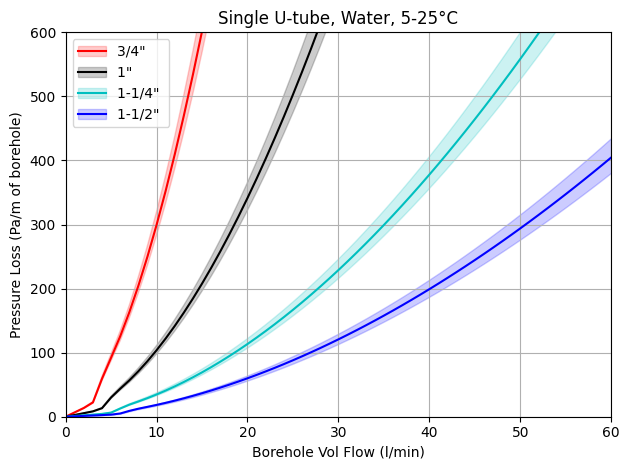

In [13]:
fig, ax = plt.subplots()

od_sizes_inch = [1.05, 1.315, 1.66, 1.9]
colors = ['r', 'k', 'c', 'b']
labels = ['3/4"', '1"', '1-1/4"', '1-1/2"']

for od, c, lab in zip(od_sizes_inch, colors, labels):
    
    dp_l, dp_m, dp_h = get_dp_range(flow_m3s, "Water", 0, od, UTubeType.SINGLE)
    plot_fill_between(flow_lpm, dp_l, dp_m, dp_h, ax, c, lab)

ax.set_xlim([0, 60])
ax.set_ylim([0, 600])
ax.set_ylabel("Pressure Loss (Pa/m of borehole)")
ax.set_xlabel("Borehole Vol Flow (l/min)")

plt.title("Single U-tube, Water, 5-25°C")
plt.tight_layout()
plt.grid()
plt.show()

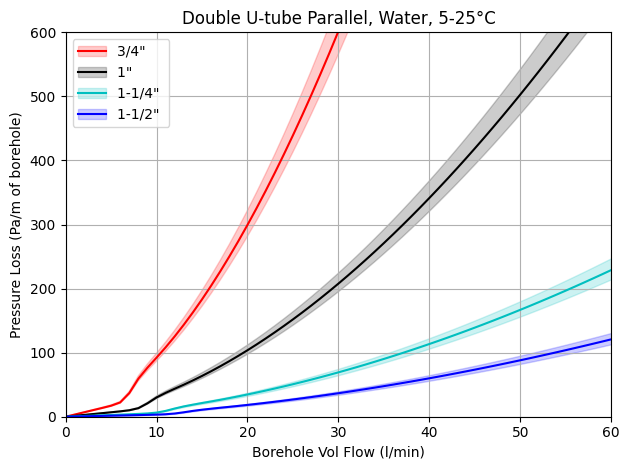

In [14]:
fig, ax = plt.subplots()

od_sizes_inch = [1.05, 1.315, 1.66, 1.9]
colors = ['r', 'k', 'c', 'b']
labels = ['3/4"', '1"', '1-1/4"', '1-1/2"']

for od, c, lab in zip(od_sizes_inch, colors, labels):
    
    dp_l, dp_m, dp_h = get_dp_range(flow_m3s, "Water", 0, od, UTubeType.DOUBLEPARALLEL)
    plot_fill_between(flow_lpm, dp_l, dp_m, dp_h, ax, c, lab)

ax.set_xlim([0, 60])
ax.set_ylim([0, 600])
ax.set_ylabel("Pressure Loss (Pa/m of borehole)")
ax.set_xlabel("Borehole Vol Flow (l/min)")

plt.title("Double U-tube Parallel, Water, 5-25°C")
plt.tight_layout()
plt.grid()
plt.show()

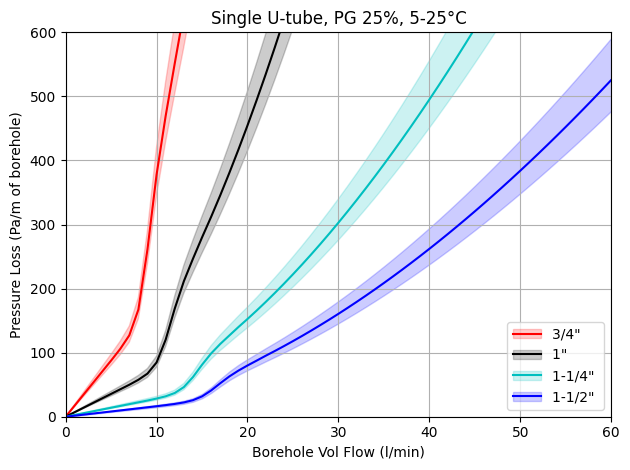

In [15]:
fig, ax = plt.subplots()

od_sizes_inch = [1.05, 1.315, 1.66, 1.9]
colors = ['r', 'k', 'c', 'b']
labels = ['3/4"', '1"', '1-1/4"', '1-1/2"']

for od, c, lab in zip(od_sizes_inch, colors, labels):
    
    dp_l, dp_m, dp_h = get_dp_range(flow_m3s, "PropyleneGlycol", 0.25, od, UTubeType.SINGLE)
    plot_fill_between(flow_lpm, dp_l, dp_m, dp_h, ax, c, lab)

ax.set_xlim([0, 60])
ax.set_ylim([0, 600])
ax.set_ylabel("Pressure Loss (Pa/m of borehole)")
ax.set_xlabel("Borehole Vol Flow (l/min)")

plt.title("Single U-tube, PG 25%, 5-25°C")
plt.tight_layout()
plt.grid()
plt.show()

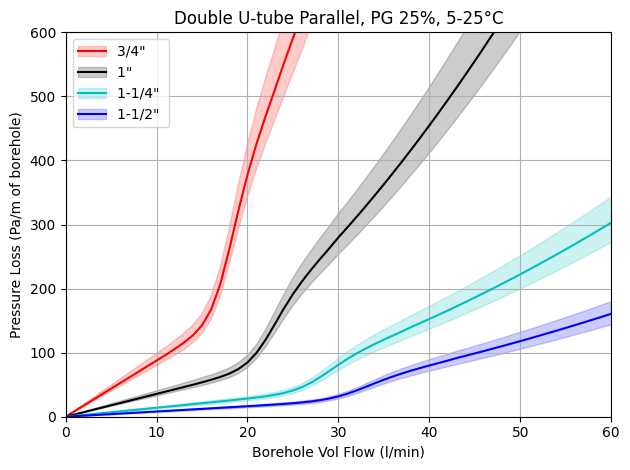

In [16]:
fig, ax = plt.subplots()

od_sizes_inch = [1.05, 1.315, 1.66, 1.9]
colors = ['r', 'k', 'c', 'b']
labels = ['3/4"', '1"', '1-1/4"', '1-1/2"']
pipe_types = [UTubeType.DOUBLEPARALLEL] * len(od_sizes_inch)

for od, c, lab, p_type in zip(od_sizes_inch, colors, labels, pipe_types):
    
    dp_l, dp_m, dp_h = get_dp_range(flow_m3s, "PropyleneGlycol", 0.25, od, p_type)
    plot_fill_between(flow_lpm, dp_l, dp_m, dp_h, ax, c, lab)

ax.set_xlim([0, 60])
ax.set_ylim([0, 600])
ax.set_ylabel("Pressure Loss (Pa/m of borehole)")
ax.set_xlabel("Borehole Vol Flow (l/min)")

plt.title("Double U-tube Parallel, PG 25%, 5-25°C")
plt.tight_layout()
plt.grid()
plt.show()

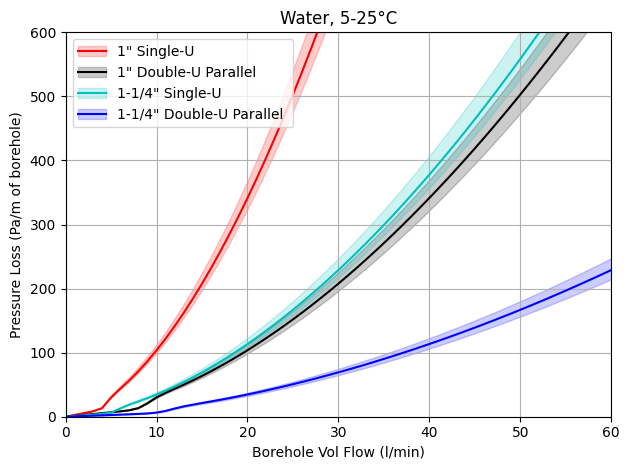

In [17]:
fig, ax = plt.subplots()

od_sizes_inch = [1.315, 1.315, 1.66, 1.66]
colors = ['r', 'k', 'c', 'b']
labels = ['1" Single-U', '1" Double-U Parallel', '1-1/4" Single-U', '1-1/4" Double-U Parallel']
pipe_types = [UTubeType.SINGLE, UTubeType.DOUBLEPARALLEL, UTubeType.SINGLE, UTubeType.DOUBLEPARALLEL]

for od, c, lab, p_type in zip(od_sizes_inch, colors, labels, pipe_types):
    
    dp_l, dp_m, dp_h = get_dp_range(flow_m3s, "Water", 0.0, od, p_type)
    plot_fill_between(flow_lpm, dp_l, dp_m, dp_h, ax, c, lab)

ax.set_xlim([0, 60])
ax.set_ylim([0, 600])
ax.set_ylabel("Pressure Loss (Pa/m of borehole)")
ax.set_xlabel("Borehole Vol Flow (l/min)")

plt.title("Water, 5-25°C")
plt.tight_layout()
plt.grid()
plt.show()

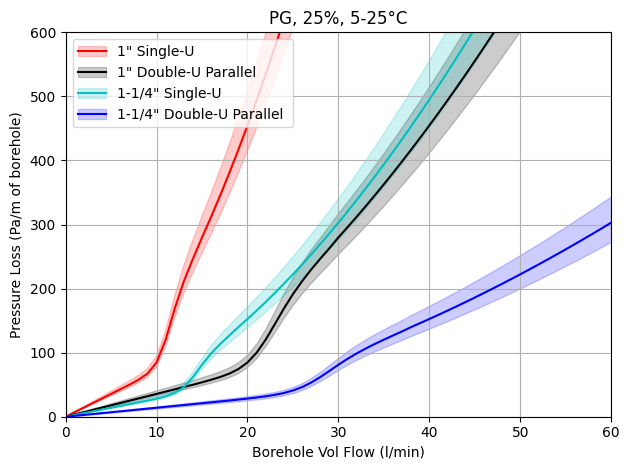

In [18]:
fig, ax = plt.subplots()

od_sizes_inch = [1.315, 1.315, 1.66, 1.66]
colors = ['r', 'k', 'c', 'b']
labels = ['1" Single-U', '1" Double-U Parallel', '1-1/4" Single-U', '1-1/4" Double-U Parallel']
pipe_types = [UTubeType.SINGLE, UTubeType.DOUBLEPARALLEL, UTubeType.SINGLE, UTubeType.DOUBLEPARALLEL]

for od, c, lab, p_type in zip(od_sizes_inch, colors, labels, pipe_types):
    
    dp_l, dp_m, dp_h = get_dp_range(flow_m3s, "PropyleneGlycol", 0.25, od, p_type)
    plot_fill_between(flow_lpm, dp_l, dp_m, dp_h, ax, c, lab)

ax.set_xlim([0, 60])
ax.set_ylim([0, 600])
ax.set_ylabel("Pressure Loss (Pa/m of borehole)")
ax.set_xlabel("Borehole Vol Flow (l/min)")

plt.title("PG, 25%, 5-25°C")
plt.tight_layout()
plt.grid()
plt.show()